In [1]:
#Import library
#Data preprocessing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
import re

#Visualization
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

#Feature Engineering
import string
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

#Machine Learning Model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Dropout,Activation,Bidirectional
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.tree import DecisionTreeClassifier

#Evaluation Metric
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
import os

from sklearn import linear_model, naive_bayes, ensemble, tree, svm, model_selection,\
                    preprocessing, feature_extraction, metrics, base, pipeline
from joblib import dump, load
import PIL


In [3]:
df = pd.read_csv("/content/drive/MyDrive/combined_data.csv")
df.head(5)

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [4]:
print(df.isnull().sum())

label    0
text     0
dtype: int64


In [5]:
df.shape


(83448, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


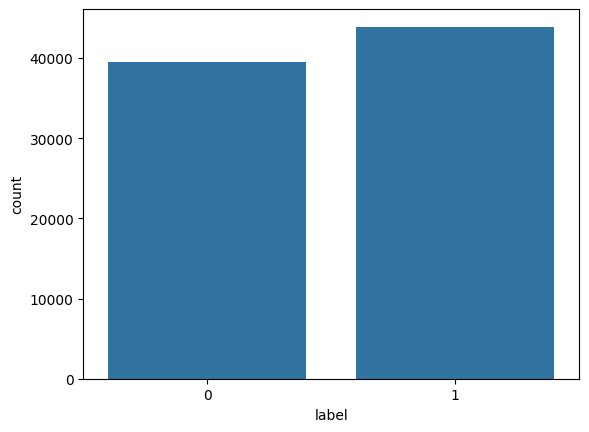

In [7]:
sns.countplot(x = 'label', data = df)
plt.show()

label
1    43910
0    39538
Name: count, dtype: int64


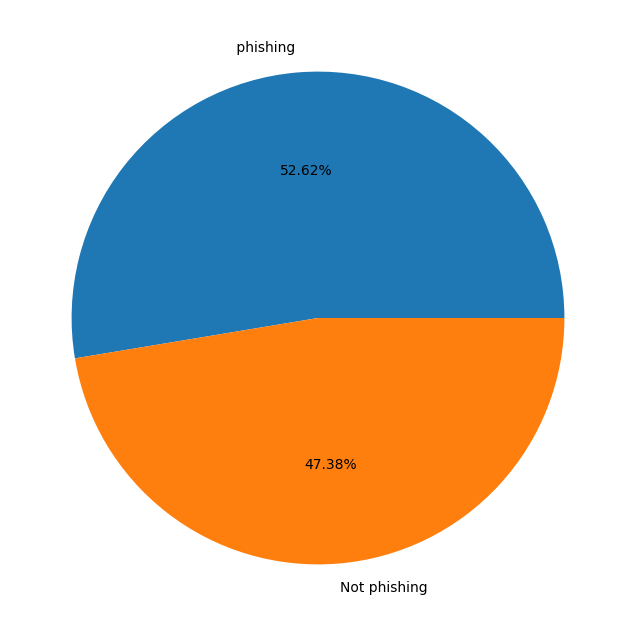

In [8]:
labels = {1 : " phishing", 0 : "Not phishing"}
label_counts = df['label'].value_counts()
print(label_counts)
plt.figure(figsize=(10, 8))
plt.pie(label_counts, labels = labels.values(), autopct = "%.2f%%")
plt.show()


In [9]:
df.sample(5)

,label,text
30570,1,http : / / bin . nepel . com
31364,1,everyone has heard about lower cost drugs from...
34679,1,http aziffm spendear hk escapenumber we escape...
45718,1,disengages himself each other objects walt whi...
22246,1,dear sirs aegis capital group llc aegis is a...


In [10]:
df['text'] = df['text'].str.lower()

In [11]:
def remove_special_characters(word):
    return word.translate(str.maketrans('', '', string.punctuation))
df['text'] = df['text'].apply(remove_special_characters)

In [12]:
#Define stop-words in English

ENGLISH_STOP_WORDS = set(stopwords.words('english'))

def remove_stop_words(words):
    return [word for word in words if word not in ENGLISH_STOP_WORDS]

#Tokenize the text
df['text'] = df['text'].apply(word_tokenize)

#Remove stop words
df['text'] = df['text'].apply(remove_stop_words)

#Rejoin words for EDA
df['text'] = df['text'].apply(' '.join)

In [13]:
def remove_hyperlink(word):
    return re.sub(r"http\S+", "", word)

df['text'] = df['text'].apply(remove_hyperlink)

In [14]:
# Separate the spam and legitimate emails
ph_emails = df[df['label'] == 1]['text']
legit_emails = df[df['label'] == 0]['text']

# Count word frequencies for spam
ph_words = Counter()
ph_emails.apply(lambda x: ph_words.update(x.split()))

# Count word frequencies for legitimate emails
legit_words = Counter()
legit_emails.apply(lambda x: legit_words.update(x.split()))

# Get the most common words in spam and legitimate emails
ph_common = ph_words.most_common(10)
legit_common = legit_words.most_common(10)

# Convert to DataFrame
ph_common_df = pd.DataFrame(ph_common, columns=['Word', 'Frequency'])
legit_common_df = pd.DataFrame(legit_common, columns=['Word', 'Frequency'])

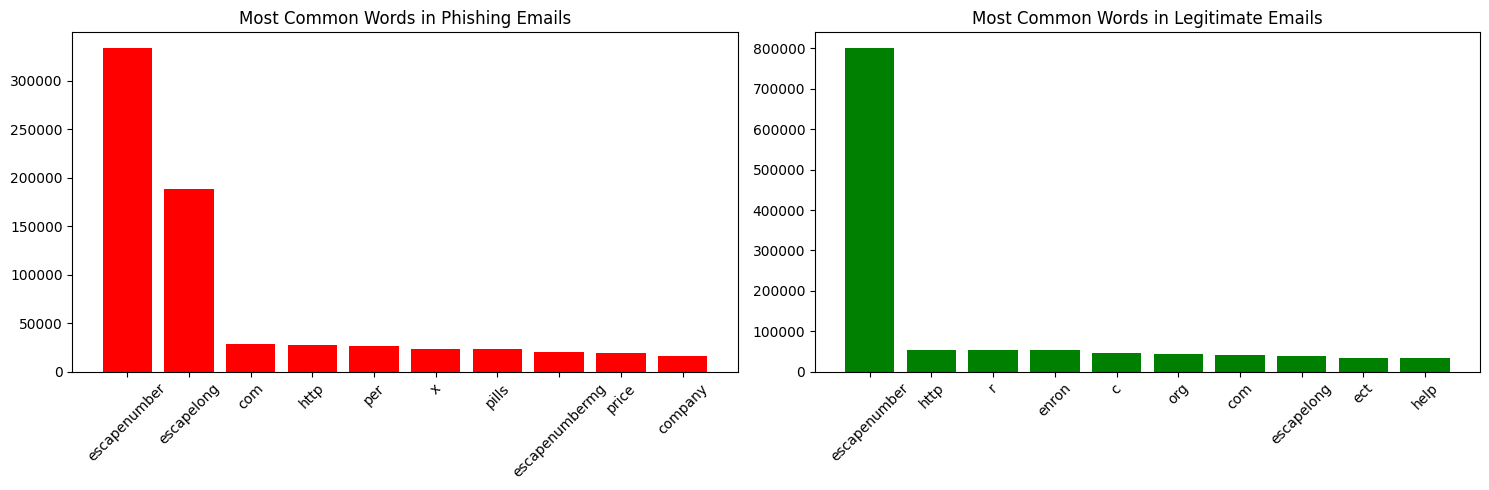

In [15]:
# Plotting the most common words in spam emails
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(ph_common_df['Word'], ph_common_df['Frequency'], color='red')
plt.title('Most Common Words in Phishing Emails')
plt.xticks(rotation=45)

# Plotting the most common words in legitimate emails
plt.subplot(1, 2, 2)
plt.bar(legit_common_df['Word'], legit_common_df['Frequency'], color='green')
plt.title('Most Common Words in Legitimate Emails')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

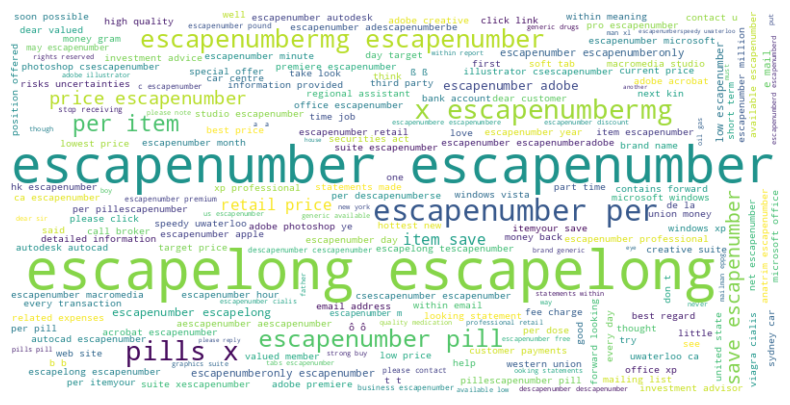

In [16]:
# Generate a word cloud image for spam words
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ph_emails))

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

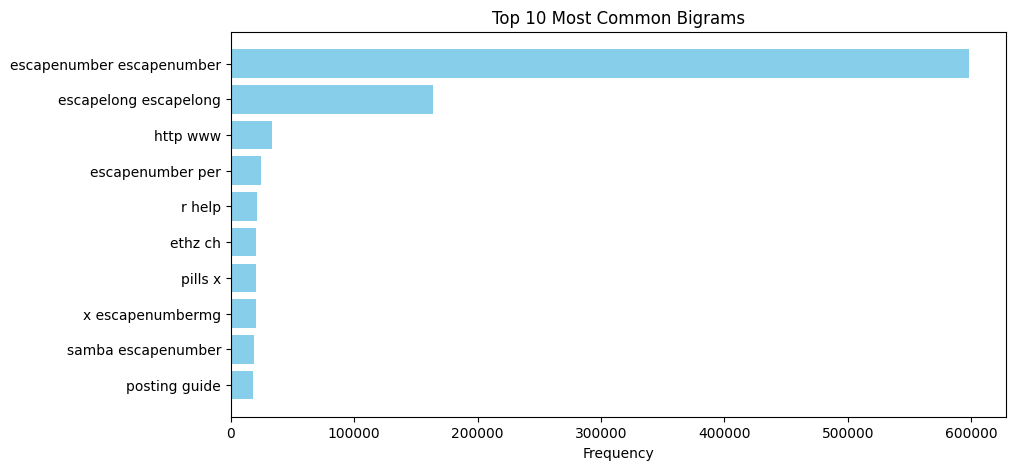

In [17]:
# Extract n-grams from text
def generate_ngrams(text, n=2):
    # Split the text into words
    words = text.split()
    # Ensure that there is no enough words
    if len(words) >= n:
        return [' '.join(grams) for grams in ngrams(words, n)]
    else:
        return []

# Convert bigrams
df['bigrams'] = df['text'].apply(lambda x: generate_ngrams(x, n=2))

# count the frequencies
bigram_counts = Counter([bigram for sublist in df['bigrams'] for bigram in sublist])

# Get the most common bigrams
most_common_bigrams = bigram_counts.most_common(10)

# Convert to DataFrame for visualization
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 5))
plt.barh(bigrams_df['Bigram'], bigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Bigrams')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [19]:
feature = cv.fit_transform(df.text)

In [20]:
feature[:27].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(feature, df.label)

In [22]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(trainX, trainY)

# Predict the target variable on the testing data
y_pred = rf_classifier.predict(testX)

# Evaluate the classifier
accuracy = accuracy_score(testY, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(testY, y_pred))


Accuracy: 0.9787652190585754
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      9908
           1       0.99      0.97      0.98     10954

    accuracy                           0.98     20862
   macro avg       0.98      0.98      0.98     20862
weighted avg       0.98      0.98      0.98     20862



In [38]:
# Replace 'new_email_text' with the text of the email you want to test
new_email_text = """ Subject: Reminder: Monthly Budget Meeting

Hi Team,

Just a friendly reminder that our monthly budget meeting is scheduled for this Friday at 2:00 PM in the conference room. We'll be discussing our financial performance for the past month and planning for the upcoming quarter.

Please ensure that you have all relevant reports and data prepared for the meeting. If you have any specific topics you'd like to address, feel free to let me know ahead of time.

Looking forward to a productive discussion!

Best regards,
dr. saad

"""


# Clean the email text (convert to lowercase, remove special characters, hyperlinks, etc.)
new_email_text = new_email_text.lower()
new_email_text = remove_special_characters(new_email_text)
new_email_text = remove_hyperlink(new_email_text)

# Tokenize the text
new_email_tokens = word_tokenize(new_email_text)

# Remove stop words
new_email_tokens = remove_stop_words(new_email_tokens)

# Rejoin the tokens into a single string
new_email_cleaned = ' '.join(new_email_tokens)

# Convert the cleaned email text into features using the same vectorizer used for training

#new_email_features = cv.transform([new_email_cleaned])
new_email_features = cv.transform([new_email_cleaned])
# Apply the trained model to predict whether the email is phishing or not

# Assuming 'X_test' contains your test data
predictions = rf_classifier.predict(new_email_features)


probability = rf_classifier.predict_proba(new_email_features)

# Print the prediction and probability score
if predictions[0] == 1:
    print("The email is classified as phishing with a probability of {:.2f}%.".format(probability[0][1] * 100))
else:
    print("The email is classified as legitimate with a probability of {:.2f}%.".format(probability[0][0] * 100))


The email is classified as legitimate with a probability of 78.00%.


In [39]:
import joblib

# Save the trained classifier
joblib.dump(rf_classifier, 'rf_classifier.joblib')


['rf_classifier.joblib']

Training Accuracy : 0.9831112389352251
Testing Accuracy : 0.9760329786214169

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.99      0.96      0.98     10130
        Good       0.97      0.99      0.98     10732

    accuracy                           0.98     20862
   macro avg       0.98      0.98      0.98     20862
weighted avg       0.98      0.98      0.98     20862


CONFUSION MATRIX


<Axes: >

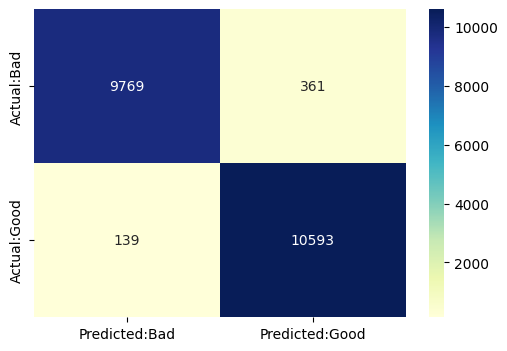

In [29]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
nb = MultinomialNB()
nb.fit(trainX, trainY)
predictions = nb.predict(testX)

print('Training Accuracy :',nb.score(trainX,trainY))
print('Testing Accuracy :',nb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(nb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(nb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [37]:
# Replace 'new_email_text' with the text of the email you want to test
new_email_text = """ Subject: Reminder: Monthly Budget Meeting

Hi Team,

Just a friendly reminder that our monthly budget meeting is scheduled for this Friday at 2:00 PM in the conference room. We'll be discussing our financial performance for the past month and planning for the upcoming quarter.

Please ensure that you have all relevant reports and data prepared for the meeting. If you have any specific topics you'd like to address, feel free to let me know ahead of time.

Looking forward to a productive discussion!

Best regards,
dr. saad



"""
# Clean the email text (convert to lowercase, remove special characters, hyperlinks, etc.)
new_email_text = new_email_text.lower()
new_email_text = remove_special_characters(new_email_text)
new_email_text = remove_hyperlink(new_email_text)

# Tokenize the text
new_email_tokens = word_tokenize(new_email_text)

# Remove stop words
new_email_tokens = remove_stop_words(new_email_tokens)

# Rejoin the tokens into a single string
new_email_cleaned = ' '.join(new_email_tokens)

# Convert the cleaned email text into features using the same vectorizer used for training

#new_email_features = cv.transform([new_email_cleaned])
new_email_features = cv.transform([new_email_cleaned])
# Apply the trained model to predict whether the email is phishing or not

# Assuming 'X_test' contains your test data
predictions = nb.predict(new_email_features)


probability = nb.predict_proba(new_email_features)

# Print the prediction and probability score
if predictions[0] == 1:
    print("The email is classified as phishing with a probability of {:.2f}%.".format(probability[0][1] * 100))
else:
    print("The email is classified as legitimate with a probability of {:.2f}%.".format(probability[0][0] * 100))


The email is classified as legitimate with a probability of 100.00%.


In [ ]:
# Replace 'new_email_text' with the text of the email you want to test
new_email_text = """ Hi Ahmed,

I hope this message finds you well. I wanted to remind you about our scheduled meeting tomorrow at 10:00 AM """
new_email_text1= new_email_text
new_email_text1=word_tokenize(new_email_text)
print(new_email_text1)
new_email_text1 = remove_stop_words(new_email_text1)
print(new_email_text1)
new_email_text1 = ' '.join(new_email_text1)
print(new_email_text1)




# Clean the email text (convert to lowercase, remove special characters, hyperlinks, etc.)
new_email_text = new_email_text.lower()
new_email_text = remove_special_characters(new_email_text)
new_email_text = remove_hyperlink(new_email_text)

# Tokenize the text
new_email_tokens = word_tokenize(new_email_text)


# Remove stop words
new_email_tokens = remove_stop_words(new_email_tokens)

# Rejoin the tokens into a single string
new_email_cleaned = ' '.join(new_email_tokens)
print(new_email_cleaned)
# Convert the cleaned email text into features using the same vectorizer used for training

#new_email_features = cv.transform([new_email_cleaned])
new_email_features = cv.transform([new_email_cleaned])
# Apply the trained model to predict whether the email is phishing or not

# Assuming 'X_test' contains your test data
predictions = nb.predict(new_email_features)


probability = nb.predict_proba(new_email_features)

# Print the prediction and probability score
if predictions[0] == 1:
    print("The email is classified as phishing with a probability of {:.2f}%.".format(probability[0][1] * 100))
else:
    print("The email is classified as legitimate with a probability of {:.2f}%.".format(probability[0][0] * 100))

['Hi', 'Ahmed', ',', 'I', 'hope', 'this', 'message', 'finds', 'you', 'well', '.', 'I', 'wanted', 'to', 'remind', 'you', 'about', 'our', 'scheduled', 'meeting', 'tomorrow', 'at', '10:00', 'AM']
['Hi', 'Ahmed', ',', 'I', 'hope', 'message', 'finds', 'well', '.', 'I', 'wanted', 'remind', 'scheduled', 'meeting', 'tomorrow', '10:00', 'AM']
Hi Ahmed , I hope message finds well . I wanted remind scheduled meeting tomorrow 10:00 AM
hi ahmed hope message finds well wanted remind scheduled meeting tomorrow 1000
The email is classified as legitimate with a probability of 96.94%.


In [ ]:
import joblib

# Save the trained classifier
joblib.dump(nb, 'nb_model.joblib')
Mr. Osama who are you?

['nb_model.joblib']

In [ ]:
nb_loaded = joblib.load('nb_model.joblib')


new_email_features = cv.transform([new_email_cleaned])
# Apply the trained model to predict whether the email is phishing or not
prediction = nb_loaded.predict(new_email_features)

# Apply the trained model to predict the probability of the email being phishing
probability = nb_loaded.predict_proba(new_email_features)

# Print the prediction and probability score
if prediction[0] == 1:
    print("The email is classified as phishing with a probability of {:.2f}%.".format(probability[0][1] * 100))
else:
    print("The email is classified as legitimate with a probability of {:.2f}%.".format(probability[0][0] * 100))


The email is classified as legitimate with a probability of 69.36%.


In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(trainX,trainY)

LogisticRegression(max_iter=1000)

The Accuracy :  0.985571853130093
Training Accuracy : 0.9982264404179848
Testing Accuracy : 0.985571853130093

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.98      0.99      0.98      9715
        Good       0.99      0.98      0.99     11147

    accuracy                           0.99     20862
   macro avg       0.99      0.99      0.99     20862
weighted avg       0.99      0.99      0.99     20862


CONFUSION MATRIX


<Axes: >

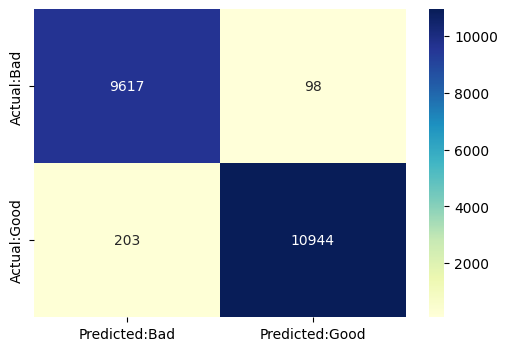

In [ ]:
print("The Accuracy : ", lr.score(testX,testY))


print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
# Replace 'new_email_text' with the text of the email you want to test
new_email_text = """
Dear dr. saad,

We are excited to extend an invitation to you for our upcoming webinar series on AI in Business: Strategies for Success. These webinars are designed to provide valuable insights and strategies to help you leverage artificial intelligence effectively in your business operations.

Event Details:

Webinar Title: AI in Business: Strategies for Success
Date: May 15, 2024
Time: 10:00 AM - 11:30 AM (PST)
Duration: 90 minutes
Key Topics:

Introduction to AI in Business
Implementing AI Solutions
Case Studies: Successful AI Integration
To reserve your spot, please click on the registration link below:


We look forward to your participation and meaningful discussions during the sessions. Should you have any questions, please don't hesitate to reach out to us at webinar@company.com or +1-800-123-4567.

Best regards,
John Smith
Marketing Manager
XYZ Corporation
"""

# Clean the email text (convert to lowercase, remove special characters, hyperlinks, etc.)
new_email_text = new_email_text.lower()
new_email_text = remove_special_characters(new_email_text)
new_email_text = remove_hyperlink(new_email_text)

# Tokenize the text
new_email_tokens = word_tokenize(new_email_text)

# Remove stop words
new_email_tokens = remove_stop_words(new_email_tokens)

# Rejoin the tokens into a single string
new_email_cleaned = ' '.join(new_email_tokens)

# Convert the cleaned email text into features using the same vectorizer used for training
new_email_features = cv.transform([new_email_cleaned])

# Apply the trained model to predict whether the email is phishing or not
prediction = lr.predict(new_email_features)

# Apply the trained model to predict the probability of the email being phishing
probability = lr.predict_proba(new_email_features)

# Print the prediction and probability score
if prediction[0] == 1:
    print("The email is classified as phishing with a probability of {:.2f}%.".format(probability[0][1] * 100))
else:
    print("The email is classified as legitimate with a probability of {:.2f}%.".format(probability[0][0] * 100))


The email is classified as phishing with a probability of 56.94%.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=1000)  # You can adjust the max_depth if needed

# Train the model on the training data
dt.fit(trainX, trainY)

DecisionTreeClassifier(max_depth=1000)

Training Accuracy : 0.9999041319144857
Testing Accuracy : 0.9618445019652958

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.97      0.95      0.96      9948
        Good       0.96      0.97      0.96     10914

    accuracy                           0.96     20862
   macro avg       0.96      0.96      0.96     20862
weighted avg       0.96      0.96      0.96     20862


CONFUSION MATRIX


<Axes: >

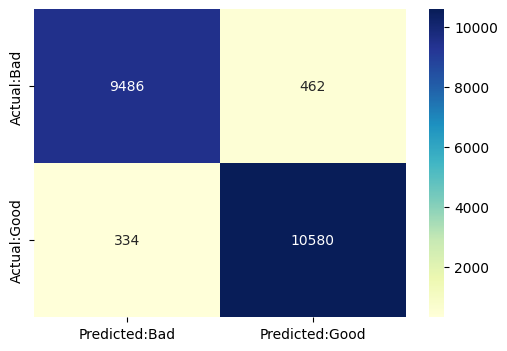

In [ ]:
print('Training Accuracy :',dt.score(trainX,trainY))
print('Testing Accuracy :',dt.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(dt.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(dt.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
dt.score(testX,testY)

0.9618445019652958

In [ ]:
from sklearn.svm import SVC



# Initialize and train the SVM Classifier
#svm_classifier = SVC(kernel='linear', random_state=0)
svm_classifier = SVC(probability=True)
svm_classifier.fit(trainX, trainY)

# Make predictions
pred_svm = svm_classifier.predict(testX)

# Evaluate performance


In [ ]:
svm_classifier.score(testX,testY)

0.9793883616144186

In [ ]:
print('Training Accuracy :',svm_classifier.score(testX,testY))
predictions = svm_classifier.predict(testX)

print('Training Accuracy :',svm_classifier.score(trainX,trainY))
print('Testing Accuracy :',svm_classifier.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(svm_classifier.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(svm_classifier.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Replace 'new_email_text' with the text of the email you want to test
new_email_text = """ Dear dr. saad,

We are excited to extend an invitation to you for our upcoming webinar series on AI in Business: Strategies for Success. These webinars are designed to provide valuable insights and strategies to help you leverage artificial intelligence effectively in your business operations.

Event Details:

Webinar Title: AI in Business: Strategies for Success
Date: May 15, 2024
Time: 10:00 AM - 11:30 AM (PST)
Duration: 90 minutes
Key Topics:

Introduction to AI in Business
Implementing AI Solutions
Case Studies: Successful AI Integration
To reserve your spot, please click on the registration link below:


We look forward to your participation and meaningful discussions during the sessions. Should you have any questions, please don't hesitate to reach out to us at webinar@company.com or +1-800-123-4567.

Best regards,
John Smith
Marketing Manager
XYZ Corporation  """

# Clean the email text (convert to lowercase, remove special characters, hyperlinks, etc.)
new_email_text = new_email_text.lower()
new_email_text = remove_special_characters(new_email_text)
new_email_text = remove_hyperlink(new_email_text)

# Tokenize the text
new_email_tokens = word_tokenize(new_email_text)

# Remove stop words
new_email_tokens = remove_stop_words(new_email_tokens)

# Rejoin the tokens into a single string
new_email_cleaned = ' '.join(new_email_tokens)

# Convert the cleaned email text into features using the same vectorizer used for training

#new_email_features = cv.transform([new_email_cleaned])
new_email_features = cv.transform([new_email_cleaned])
# Apply the trained model to predict whether the email is phishing or not

# Assuming 'X_test' contains your test data
predictions = svm_classifier.predict(new_email_features)




# Print the prediction and probability score
if predictions[0] == 1:
    print("The email is classified as phishing with a probability of {:.2f}%.")
else:
    print("The email is classified as legitimate with a probability of {:.2f}%.")

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
accuracy = [lr.score(testX, testY), dt.score(testX, testY), nb.score(testX, testY),svm_classifier.score(testX,testY)]
output = pd.DataFrame({"Model": ['LogisticRegression', 'Decision Tree Classifier', 'MultinomialNB','svm_classifier'],
                       "Accuracy": accuracy})

In [ ]:
output

,Model,Accuracy
0,LogisticRegression,0.985572
1,Decision Tree Classifier,0.961845
2,MultinomialNB,0.977279
3,svm_classifier,0.979388


from matplotlib import pyplot as plt
output['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
output.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
output['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(output['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(output, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
nb.score(testX,testY)

0.9772792637331033

In [ ]:
import joblib

# Save the trained classifier
joblib.dump(nb, 'nb_model.pkl')


['nb_model.pkl']

In [ ]:
X = df['text']
y = df['label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
#Average Length
average_length = df['text'].apply(len).mean()
print("Average Length: "+str(average_length))

Average Length: 1305.4409692263446


In [ ]:
max_length = 500 #Set to average length

# Padding sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
embedding_vector_length = 32
model = tf.keras.Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length=max_length))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 bidirectional (Bidirection  (None, 128)               49664     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 211745 (827.13 KB)
Trainable params: 211745 (827.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
history = model.fit(X_train_padded, y_train_encoded,
                    batch_size=512,
                    epochs=20,
                    validation_data=(X_test_padded, y_test_encoded))

Epoch 1/20
115/115 [==============================] - 488s 4s/step - loss: 0.2729 - accuracy: 0.8761 - val_loss: 0.0766 - val_accuracy: 0.9773
Epoch 2/20
115/115 [==============================] - 492s 4s/step - loss: 0.1607 - accuracy: 0.9624 - val_loss: 0.1605 - val_accuracy: 0.9670
Epoch 3/20
115/115 [==============================] - 498s 4s/step - loss: 0.1055 - accuracy: 0.9721 - val_loss: 0.0688 - val_accuracy: 0.9787
Epoch 4/20
115/115 [==============================] - 493s 4s/step - loss: 0.0466 - accuracy: 0.9865 - val_loss: 0.0704 - val_accuracy: 0.9791
Epoch 5/20
115/115 [==============================] - 488s 4s/step - loss: 0.0358 - accuracy: 0.9897 - val_loss: 0.0721 - val_accuracy: 0.9803
Epoch 6/20
115/115 [==============================] - 489s 4s/step - loss: 0.0299 - accuracy: 0.9921 - val_loss: 0.0679 - val_accuracy: 0.9815
Epoch 7/20
115/115 [==============================] - 487s 4s/step - loss: 0.0453 - accuracy: 0.9860 - val_loss: 0.0989 - val_accuracy: 0.9708

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]

783/783 [==============================] - 120s 150ms/step


In [ ]:
cf_matrix =confusion_matrix(y_test_encoded,y_predict)
tn, fp, fn, tp = confusion_matrix(y_test_encoded,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test_encoded, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test_encoded, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test_encoded,y_predict)))

Precision: 98.05%
Recall: 98.43%
F1 Score: 98.24%


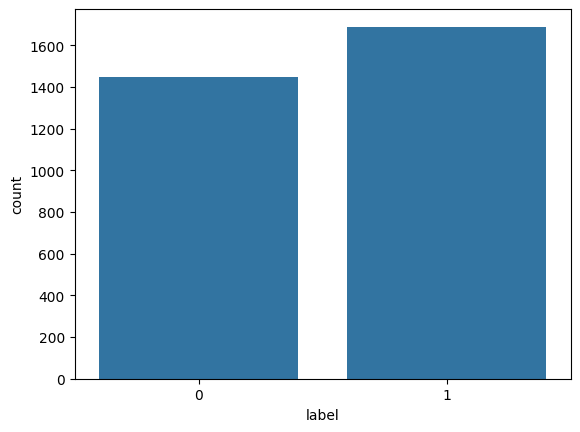

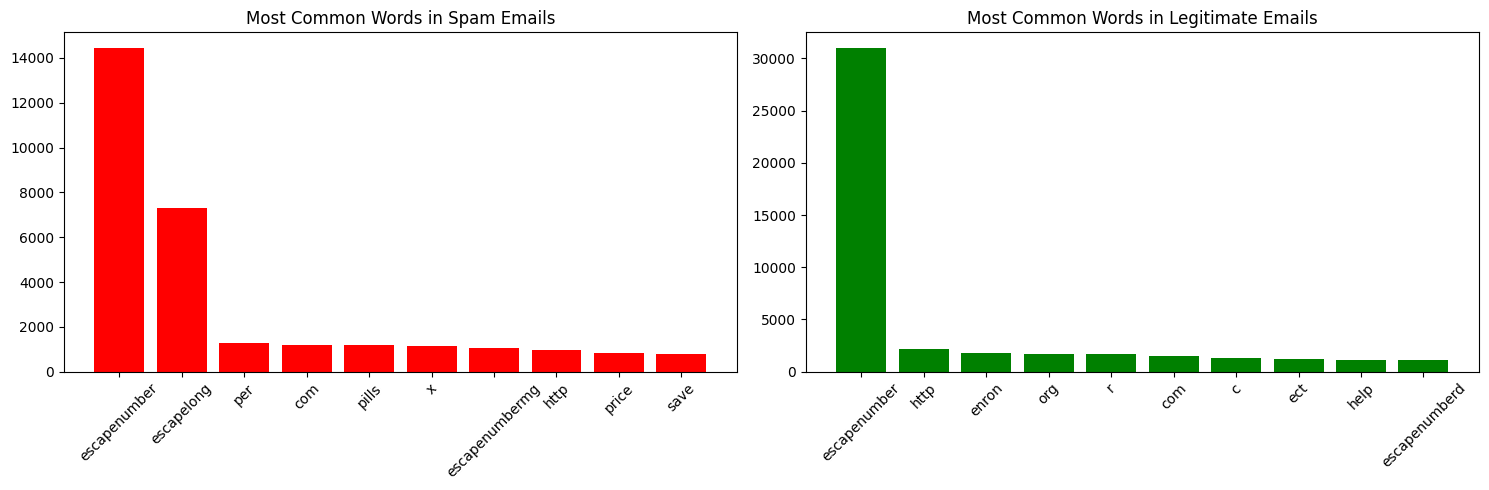

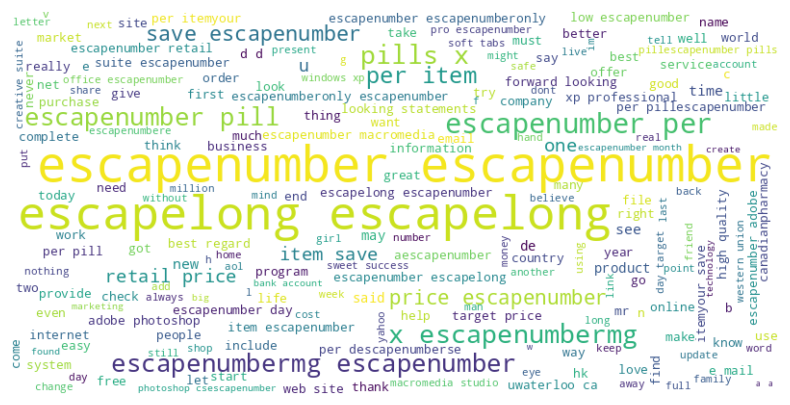

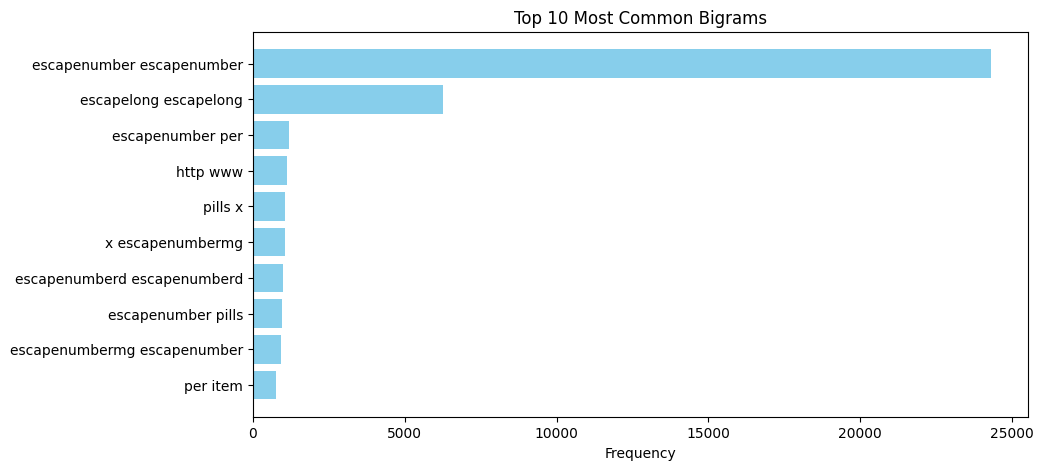

Training Accuracy: 0.9982993197278912
Testing Accuracy: 0.9681528662420382

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.94      0.99      0.97       348
        Good       1.00      0.95      0.97       437

    accuracy                           0.97       785
   macro avg       0.97      0.97      0.97       785
weighted avg       0.97      0.97      0.97       785


CONFUSION MATRIX


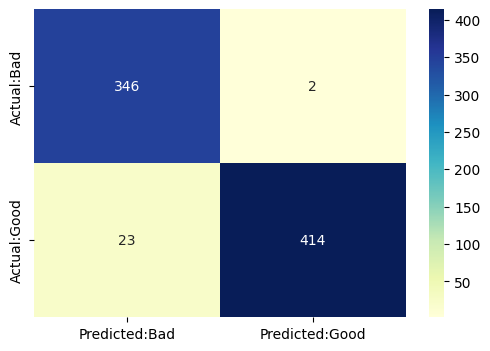

Training Accuracy: 1.0
Testing Accuracy: 0.913375796178344

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.92      0.90      0.91       381
        Good       0.90      0.93      0.92       404

    accuracy                           0.91       785
   macro avg       0.91      0.91      0.91       785
weighted avg       0.91      0.91      0.91       785


CONFUSION MATRIX


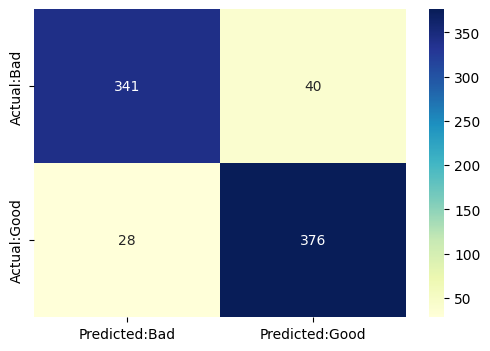

Training Accuracy: 0.9897959183673469
Testing Accuracy: 0.9681528662420382

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.98      0.95      0.97       380
        Good       0.96      0.98      0.97       405

    accuracy                           0.97       785
   macro avg       0.97      0.97      0.97       785
weighted avg       0.97      0.97      0.97       785


CONFUSION MATRIX


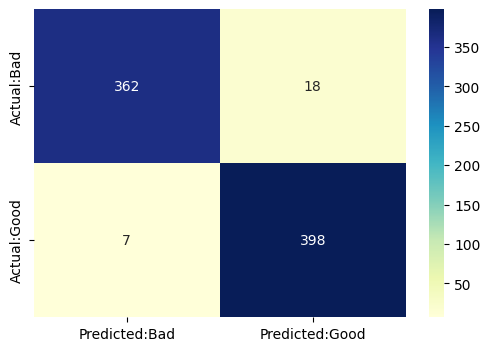

In [ ]:
class PhishingDetector:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None
        self.stop_words = set(stopwords.words('english'))

    def load_data(self):
        self.df = pd.read_csv(self.data_path)

    def preprocess_data(self):
        if self.df is not None:
            self.df['text'] = self.df['text'].str.lower()
            self.df['text'] = self.df['text'].apply(self.remove_special_characters)
            self.df['text'] = self.df['text'].apply(self.remove_hyperlink)
            self.df['text'] = self.df['text'].apply(word_tokenize)
            self.df['text'] = self.df['text'].apply(self.remove_stop_words)
            self.df['text'] = self.df['text'].apply(' '.join)

    def remove_special_characters(self, word):
        return word.translate(str.maketrans('', '', string.punctuation))

    def remove_stop_words(self, words):
        return [word for word in words if word not in self.stop_words]

    def remove_hyperlink(self, word):
        return re.sub(r"http\S+", "", word)

    def visualize_data(self):
        if self.df is not None:
            sns.countplot(x='label', data=self.df)
            plt.show()

    def analyze_word_frequencies(self):
        if self.df is not None:
            spam_emails = self.df[self.df['label'] == 1]['text']
            legit_emails = self.df[self.df['label'] == 0]['text']

            spam_words = Counter()
            spam_emails.apply(lambda x: spam_words.update(x.split()))

            legit_words = Counter()
            legit_emails.apply(lambda x: legit_words.update(x.split()))

            spam_common = spam_words.most_common(10)
            legit_common = legit_words.most_common(10)

            spam_common_df = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
            legit_common_df = pd.DataFrame(legit_common, columns=['Word', 'Frequency'])

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 2, 1)
            plt.bar(spam_common_df['Word'], spam_common_df['Frequency'], color='red')
            plt.title('Most Common Words in Spam Emails')
            plt.xticks(rotation=45)

            plt.subplot(1, 2, 2)
            plt.bar(legit_common_df['Word'], legit_common_df['Frequency'], color='green')
            plt.title('Most Common Words in Legitimate Emails')
            plt.xticks(rotation=45)

            plt.tight_layout()
            plt.show()

    def generate_wordcloud(self):
        if self.df is not None:
            spam_emails = self.df[self.df['label'] == 1]['text']
            spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_emails))
            plt.figure(figsize=(10, 5))
            plt.imshow(spam_wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.show()

    def extract_ngrams(self):
        if self.df is not None:
            self.df['bigrams'] = self.df['text'].apply(lambda x: self.generate_ngrams(x, n=2))
            bigram_counts = Counter([bigram for sublist in self.df['bigrams'] for bigram in sublist])
            most_common_bigrams = bigram_counts.most_common(10)
            bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])
            plt.figure(figsize=(10, 5))
            plt.barh(bigrams_df['Bigram'], bigrams_df['Frequency'], color='skyblue')
            plt.xlabel('Frequency')
            plt.title('Top 10 Most Common Bigrams')
            plt.gca().invert_yaxis()
            plt.show()

    def generate_ngrams(self, text, n=2):
        words = text.split()
        if len(words) >= n:
            return [' '.join(grams) for grams in ngrams(words, n)]
        else:
            return []

    def feature_extraction(self):
        if self.df is not None:
            cv = CountVectorizer()
            feature = cv.fit_transform(self.df.text)
            return feature, self.df.label

    def train_test_split(self, feature, label):
        return train_test_split(feature, label)

    def logistic_regression(self, trainX, trainY, testX, testY):
        lr = LogisticRegression(max_iter=1000)
        lr.fit(trainX, trainY)
        self.evaluate_model(lr, trainX, trainY, testX, testY)

    def decision_tree(self, trainX, trainY, testX, testY):
        dt = DecisionTreeClassifier(max_depth=1000)
        dt.fit(trainX, trainY)
        self.evaluate_model(dt, trainX, trainY, testX, testY)

    def naive_bayes(self, trainX, trainY, testX, testY):
        nb = MultinomialNB()
        nb.fit(trainX, trainY)
        self.evaluate_model(nb, trainX, trainY, testX, testY)

    def evaluate_model(self, model, trainX, trainY, testX, testY):
        print('Training Accuracy:', model.score(trainX, trainY))
        print('Testing Accuracy:', model.score(testX, testY))
        y_pred = model.predict(testX)
        con_mat = pd.DataFrame(confusion_matrix(y_pred, testY), columns=['Predicted:Bad', 'Predicted:Good'],
                               index=['Actual:Bad', 'Actual:Good'])
        print('\nCLASSIFICATION REPORT\n')
        print(classification_report(y_pred, testY, target_names=['Bad', 'Good']))
        print('\nCONFUSION MATRIX')
        plt.figure(figsize=(6, 4))
        sns.heatmap(con_mat, annot=True, fmt='d', cmap="YlGnBu")
        plt.show()

# Usage
data_path = "/content/combined_data.csv"
phishing_detector = PhishingDetector(data_path)
phishing_detector.load_data()
phishing_detector.preprocess_data()
phishing_detector.visualize_data()
phishing_detector.analyze_word_frequencies()
phishing_detector.generate_wordcloud()
phishing_detector.extract_ngrams()
feature, label = phishing_detector.feature_extraction()
trainX, testX, trainY, testY = phishing_detector.train_test_split(feature, label)
phishing_detector.logistic_regression(trainX, trainY, testX, testY)
phishing_detector.decision_tree(trainX, trainY, testX, testY)
phishing_detector.naive_bayes(trainX, trainY, testX, testY)
